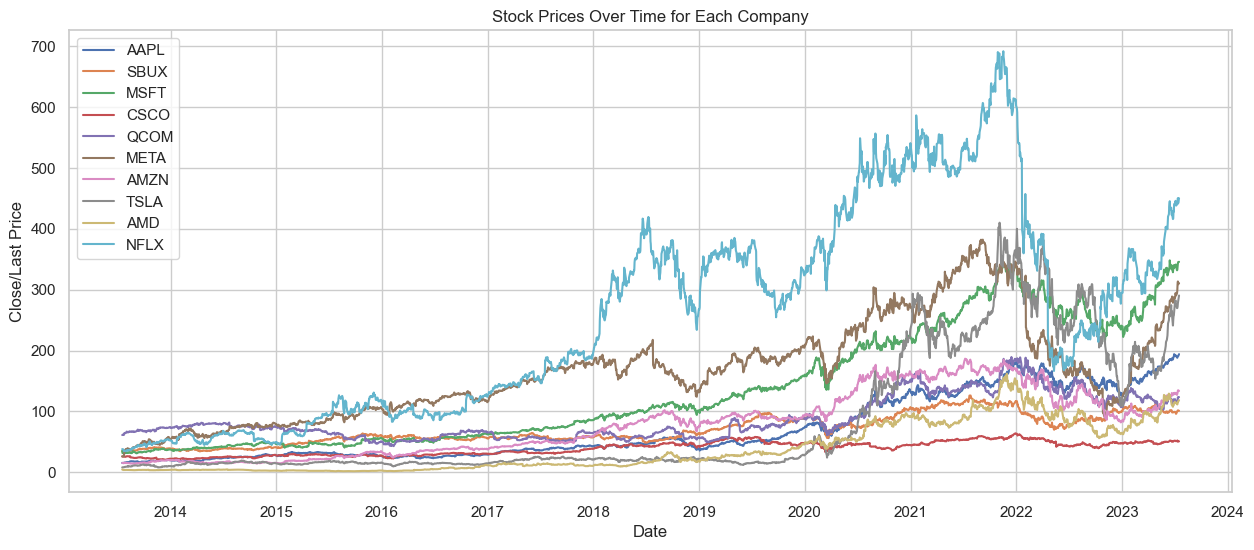

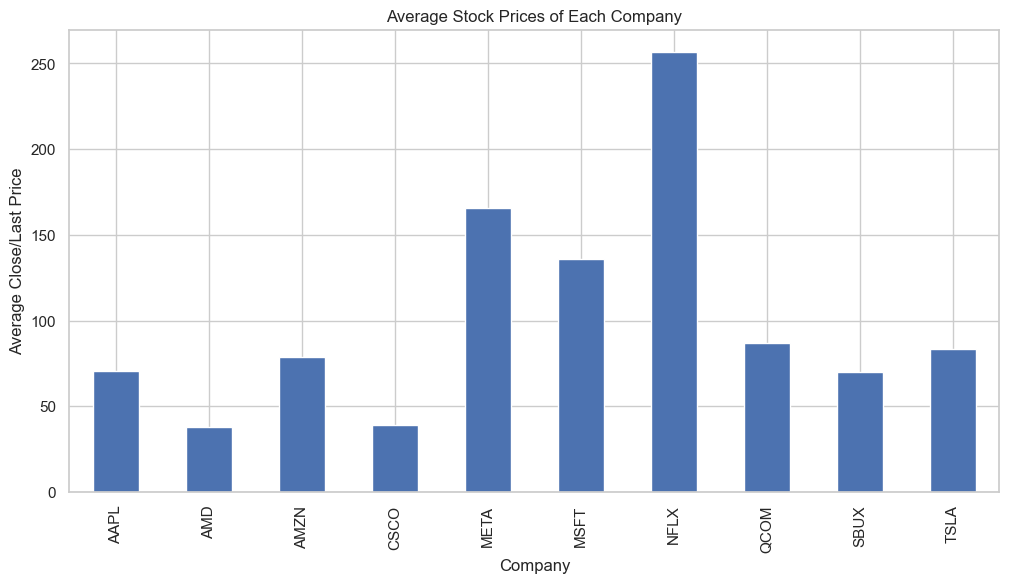

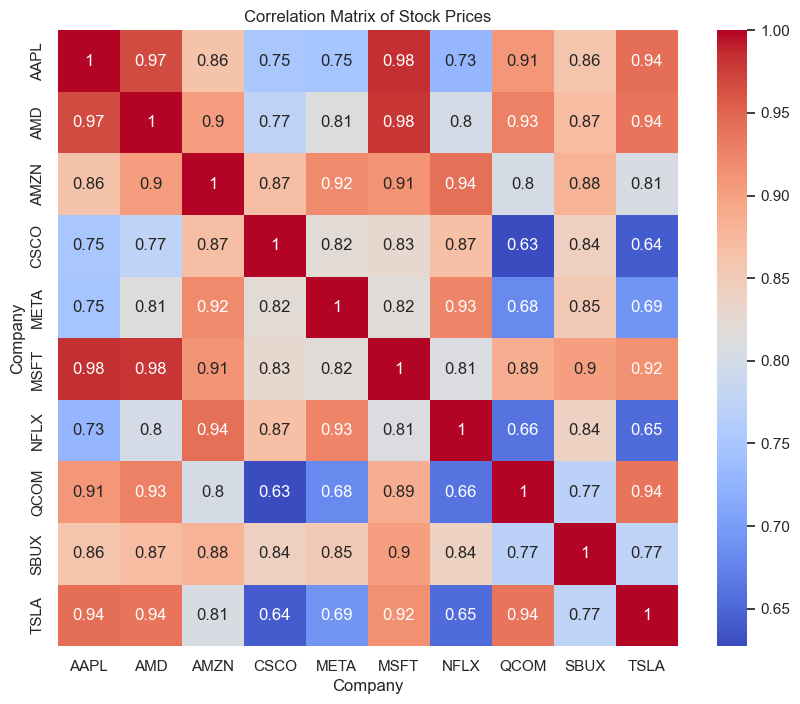

Volatility (Standard Deviation of Daily Returns):
Company
AAPL    0.018045
AMD     0.035944
AMZN    0.020743
CSCO    0.016005
META    0.024965
MSFT    0.017322
NFLX    0.029301
QCOM    0.022055
SBUX    0.016510
TSLA    0.035505
Name: Daily Return, dtype: float64

Potential Stocks (Sorted by Higher Average Daily Return and Lower Volatility):
         Volatility  Average Daily Return
Company                                  
QCOM       0.022055             -0.000037
CSCO       0.016005             -0.000142
SBUX       0.016510             -0.000294
NFLX       0.029301             -0.000569
AMD        0.035944             -0.000639
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=476.434, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=458.761, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=446.829, Time=0.07 sec
 AR

C:\Users\86159\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\86159\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


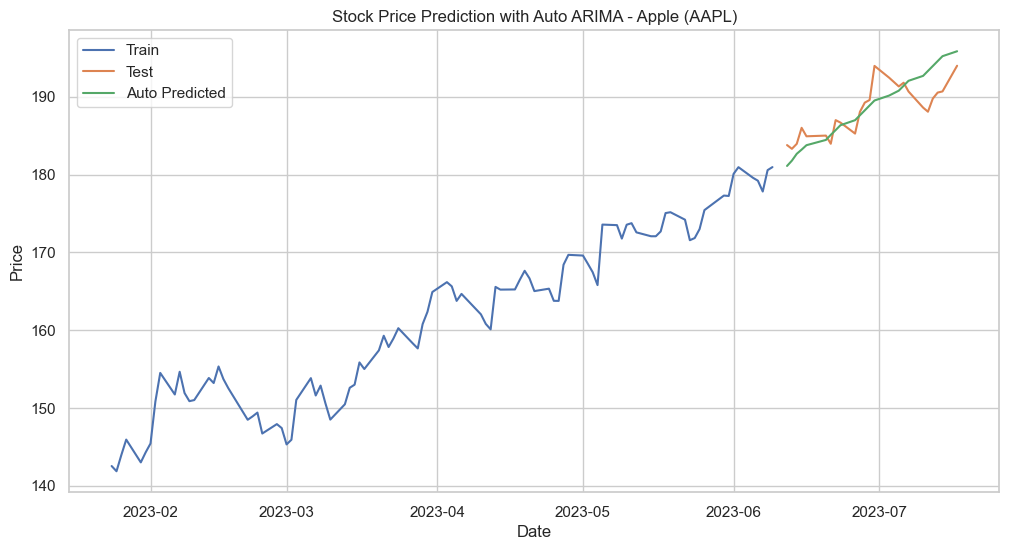

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

file_path="C:/users/86159/Desktop/stock.csv"
stock_data=pd.read_csv(file_path)
stock_data.head()

stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# 将所有价格列转换为数值型
price_columns = ['Close/Last', 'Open', 'High', 'Low']
for col in price_columns:
    stock_data[col] = stock_data[col].replace('[\$,]', '', regex=True).astype(float)
# 去除缺失值
missing_values = stock_data.isnull().sum()

# Set the style of the visualization
sns.set(style="whitegrid")
# 1. 折线图
plt.figure(figsize=(15, 6))
for company in stock_data['Company'].unique():
    company_data = stock_data[stock_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Close/Last'], label=company)
plt.title('Stock Prices Over Time for Each Company')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()

# 2. 条形图
avg_prices = stock_data.groupby('Company')['Close/Last'].mean()
plt.figure(figsize=(12, 6))
avg_prices.plot(kind='bar')
plt.title('Average Stock Prices of Each Company')
plt.xlabel('Company')
plt.ylabel('Average Close/Last Price')
plt.show()

# 3. 热图
correlation_matrix = stock_data.pivot_table(values='Close/Last', index='Date', columns='Company').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Prices')
plt.show()

#股票不动性分析

# 计算每个公司每日股票收益率
stock_data['Daily Return'] = stock_data.groupby('Company')['Close/Last'].pct_change()
# 计算每个公司股票收益率的波动性（标准差）
volatility = stock_data.groupby('Company')['Daily Return'].std()
print("Volatility (Standard Deviation of Daily Returns):")
print(volatility)

# 计算每个公司的平均每日收益率
avg_daily_return = stock_data.groupby('Company')['Daily Return'].mean()

# 推荐潜力股（选择平均日收益率较高、波动性较低的股票）
potential_stocks = pd.DataFrame({
    'Volatility': volatility,
    'Average Daily Return': avg_daily_return
}).sort_values(by=['Average Daily Return','Volatility',], ascending=[False,True])

print("\nPotential Stocks (Sorted by Higher Average Daily Return and Lower Volatility):")
print(potential_stocks.head())  # 展示推荐的几个股票


# 设置日期列为索引
stock_data.set_index('Date', inplace=True)


# 选择AAPL公司股票的Close/Last列进行分析
aapl_data = stock_data[stock_data['Company'] == 'AAPL']['Close/Last']

aapl_data = aapl_data.sort_index()  # 确保数据按照日期升序排列
# 使用最近120天的数据
aapl_recent = aapl_data[-120:]


# 分割数据为训练集和测试集。取80%的数据作训练集。
train_size = int(len(aapl_recent) * 0.8)
train, test = aapl_recent[0:train_size], aapl_recent[train_size:]


# 使用 auto_arima 自动寻找最佳 ARIMA 模型参数
auto_model = auto_arima(train,start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   d=2,
                   test='adf',       # 使用adf测试来寻找最佳的差分阶数d
                   m=1,              # 数据的季节性周期
                   seasonal=True,   # 考虑季节性
                   start_P=0, 
                   D=0, 
                   trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# 输出最佳模型的概要信息
print(auto_model.summary())

# 使用找到的最佳参数对测试集进行预测
predictions = auto_model.predict(n_periods=len(test))



# 评估模型性能
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print("\nAuto ARIMA Model Performance:")
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",rmse)

# 绘制实际值与预测值的对比图
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Auto Predicted')
plt.title('Stock Price Prediction with Auto ARIMA - Apple (AAPL)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()